<a href="https://colab.research.google.com/github/AbdelRayan/AutomaticSleepScoring/blob/main/Faranak/Complexity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

## Libraries

In [95]:
%%capture
# !pip install neurodsp
# !pip install emd
# !pip install tslearn
# !pip install dtaidistance
# !pip install sails
# !pip install specparam
# !pip install EntropyHub

In [ ]:
import scipy
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails
import requests
from io import BytesIO
from scipy.fftpack import fft
from scipy.signal import welch
from specparam import SpectralModel
from neurodsp.aperiodic import compute_fluctuations
from scipy.stats import zscore
from scipy.signal import savgol_filter
import EntropyHub as EH
import yaml
import os

##Colors

In [97]:
Red = '#d13838'
Blue = '#127be3'
DarkBlue = '#09217a'
LightBlue = '#9cd4ff'
Yellow = '#eff250'
Orange = '#faac11'
Purple = '#a170fd'

# Data

In [ ]:
with open('visualization_config.yaml') as p:
    params = yaml.safe_load(p)

In [ ]:
# EEG sampling frequency
fs = params['general']['fs']
# epochs in seconds
epoch_length = params['general']['epoch_length']
window_size = epoch_length * fs
step_size = window_size  # In case we wanted overlap later.

In [ ]:
# base path for all data
data_path = params['general']['data_path']

# input
path_to_input = params['feature']['path_to_input']
input_path = os.path.join(data_path, path_to_input)

# output
path_to_vis = params['feature']['path_to_vis']
category = params['feature']['category']
subject = params['general']['subject']
output_path = os.path.join(data_path, path_to_vis, category, subject)

# try to create directory
try:
    os.mkdir(output_path)
except OSError as e:
    print(e)
    print("Manually remove the directory to create a new one.\nOr add created files to this directory.")

In [ ]:
fpz = loadmat(os.path.join(input_path, f'{subject}_Fpz-Cz.mat'))
states = loadmat(os.path.join(input_path, f'{subject}_sleep_states.mat'))

In [ ]:
fpz = np.squeeze(fpz['Fpz-Cz'])
states = states['States'].flatten()

In [102]:
fpz_len = len(fpz)//100//60
states_len = len(states)//60
print(f"EEG epoch length: {fpz_len} - States epoch lenght: {states_len}")

EEG epoch length: 420 - States epoch lenght: 420


# 1. Visualizations

## Aperiodic Fit

C:\Users\andri\AppData\Local\Temp\ipykernel_28604\680999755.py:10: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  freqs, psd = welch(window_data, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\680999755.py:10: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  freqs, psd = welch(window_data, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\680999755.py:10: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  freqs, psd = welch(window_data, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\680999755.py:10: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  freqs, psd = welch(window_data, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\680999755.py:10: UserWarning: nperseg=4096

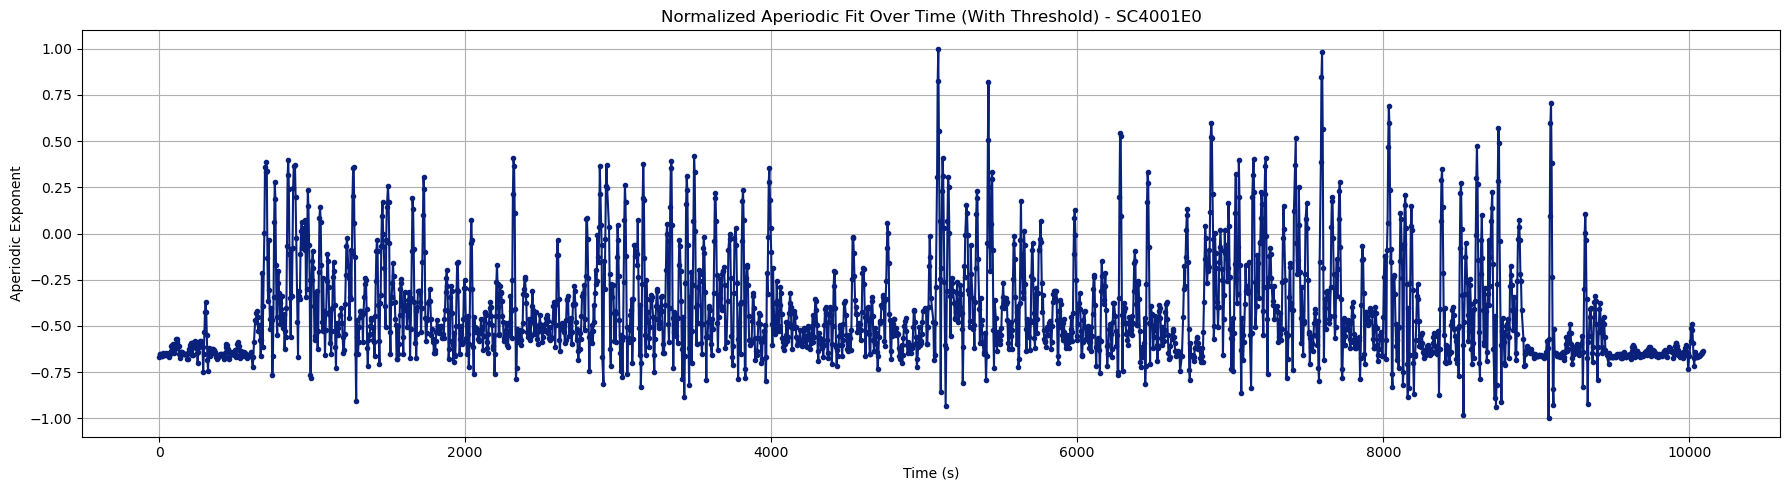

In [103]:
num_windows = len(fpz) // window_size
time_stamps = np.arange(num_windows) * 4

aperiodic_exponents = []

for i in range(num_windows):
    start, end = i * window_size, (i + 1) * window_size
    window_data = fpz[start:end]

    freqs, psd = welch(window_data, fs=fs, nperseg=4096)

    mask = (freqs <= 100)
    freqs, psd = freqs[mask], psd[mask]

    fm = SpectralModel(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
    fm.fit(freqs, psd)

    aperiodic_exponents.append(fm.get_params('aperiodic')[1])

aperiodic_exponents = np.array(aperiodic_exponents)

# Thresholding to remove outliers
threshold_min = np.percentile(aperiodic_exponents, 2)
threshold_max = np.percentile(aperiodic_exponents, 98)
valid_indices = (aperiodic_exponents >= threshold_min) & (aperiodic_exponents <= threshold_max)

filtered_exponents = aperiodic_exponents[valid_indices]
filtered_timestamps = time_stamps[valid_indices]

#filtered_exponents_z = (filtered_exponents - np.mean(filtered_exponents)) / np.std(filtered_exponents)
window_length = 11 if len(filtered_exponents) >= 11 else len(filtered_exponents) | 1  # ensure it's odd
polyorder = 4

smoothed_exponents = savgol_filter(filtered_exponents, window_length=window_length, polyorder=polyorder)
normalized_exponents = 2 * ((smoothed_exponents - min(smoothed_exponents)) /(max(smoothed_exponents) - min(smoothed_exponents))) - 1

plt.figure(figsize=(18, 5))
plt.plot(filtered_timestamps, normalized_exponents, marker='.', linestyle='-', color=DarkBlue)
plt.xlabel('Time (s)')
plt.ylabel('Aperiodic Exponent')
plt.title(f'Normalized Aperiodic Fit Over Time (With Threshold) - {subject}')
#plt.axhline(0, color='r', linestyle='--', label='Mean')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## DFA

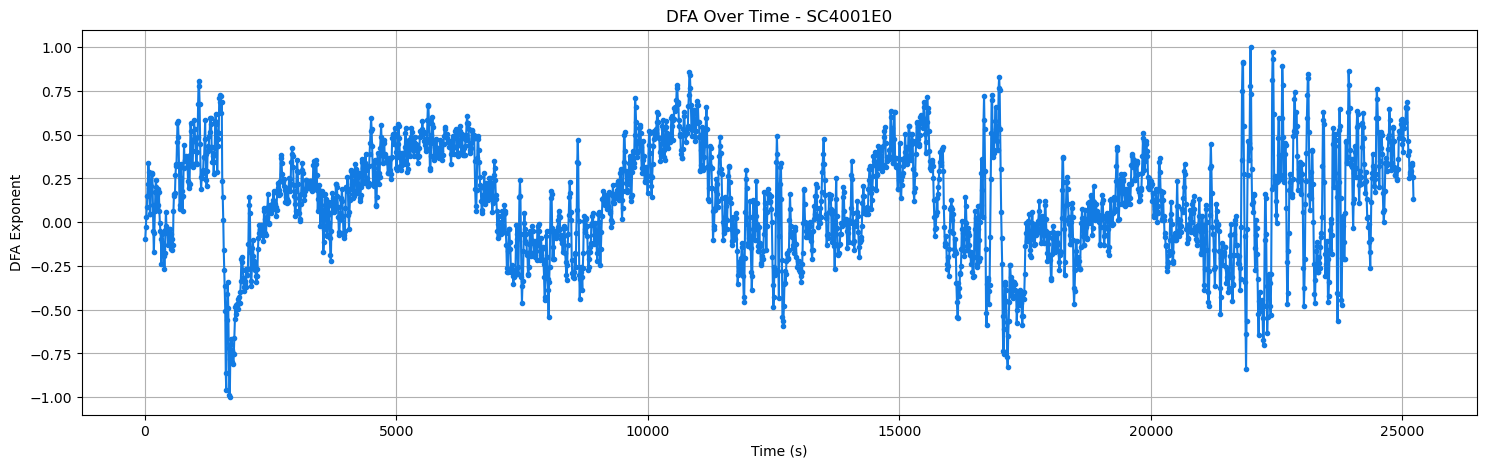

In [104]:
num_windows = (len(fpz) - window_size) // step_size + 1

dfa_exponents = []
time_stamps = []

for i in range(num_windows):
    start = i * step_size
    end = start + window_size
    segment = fpz[start:end]

    _, _, exp_window = compute_fluctuations(segment, fs, n_scales=10,
                                            min_scale=0.05, max_scale=4.0)

    dfa_exponents.append(exp_window)
    time_stamps.append((start + end) / 2 / fs)

dfa_exponents = np.array(dfa_exponents)
window_length = 11 if len(dfa_exponents) >= 11 else len(dfa_exponents) | 1  # ensure it's odd
polyorder = 4

smoothed_dfa = savgol_filter(dfa_exponents, window_length=window_length, polyorder=polyorder)
normalized_dfa = 2 * ((smoothed_dfa - min(smoothed_dfa)) /(max(smoothed_dfa) - min(smoothed_dfa))) - 1
plt.figure(figsize=(18, 5))
plt.plot(time_stamps, normalized_dfa, marker='.', linestyle='-', color=Blue)
plt.xlabel('Time (s)')
plt.ylabel('DFA Exponent')
plt.title(f'DFA Over Time - {subject}')
plt.grid()
plt.show()

## MSE

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

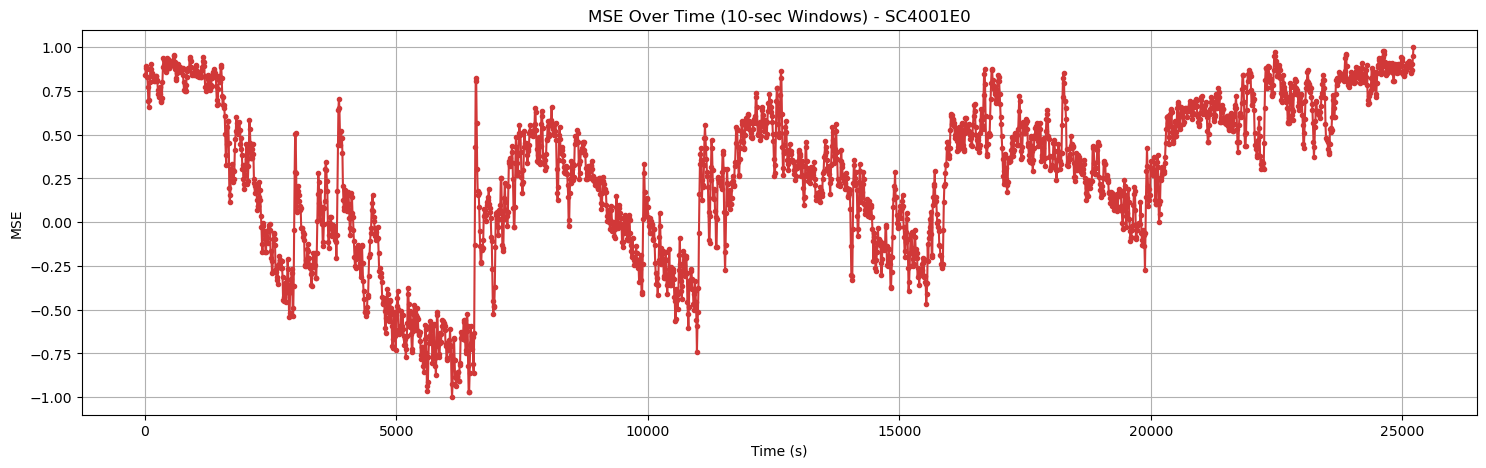

In [105]:
Mobj = EH.MSobject('IncrEn', m=2, R=3, Norm=True)

num_windows = (len(fpz) - window_size) // step_size + 1

mse_values = []
time_stamps_mse = []

for i in range(num_windows):
    start = i * step_size
    end = start + window_size
    segment = fpz[start:end]

    MSx, _ = EH.MSEn(segment, Mobj, Scales=2, Methodx='modified')

    mse_values.append(np.mean(MSx))
    time_stamps_mse.append((start + end) / 2 / fs)

mse_values = np.array(mse_values)
time_stamps_mse = np.array(time_stamps_mse)
window_length = 11 if len(mse_values) >= 11 else len(mse_values) | 1  # ensure it's odd
polyorder = 4

smoothed_mse = savgol_filter(mse_values, window_length=window_length, polyorder=polyorder)
normalized_mse = 2 * ((smoothed_mse - min(smoothed_mse)) /(max(smoothed_mse) - min(smoothed_mse))) - 1

plt.figure(figsize=(18, 5))
plt.plot(time_stamps_mse, normalized_mse, marker='.', linestyle='-', color=Red)
plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.title(f'MSE Over Time ({epoch_length}-sec Windows) - {subject}')
plt.grid()
plt.show()

## Final Plot

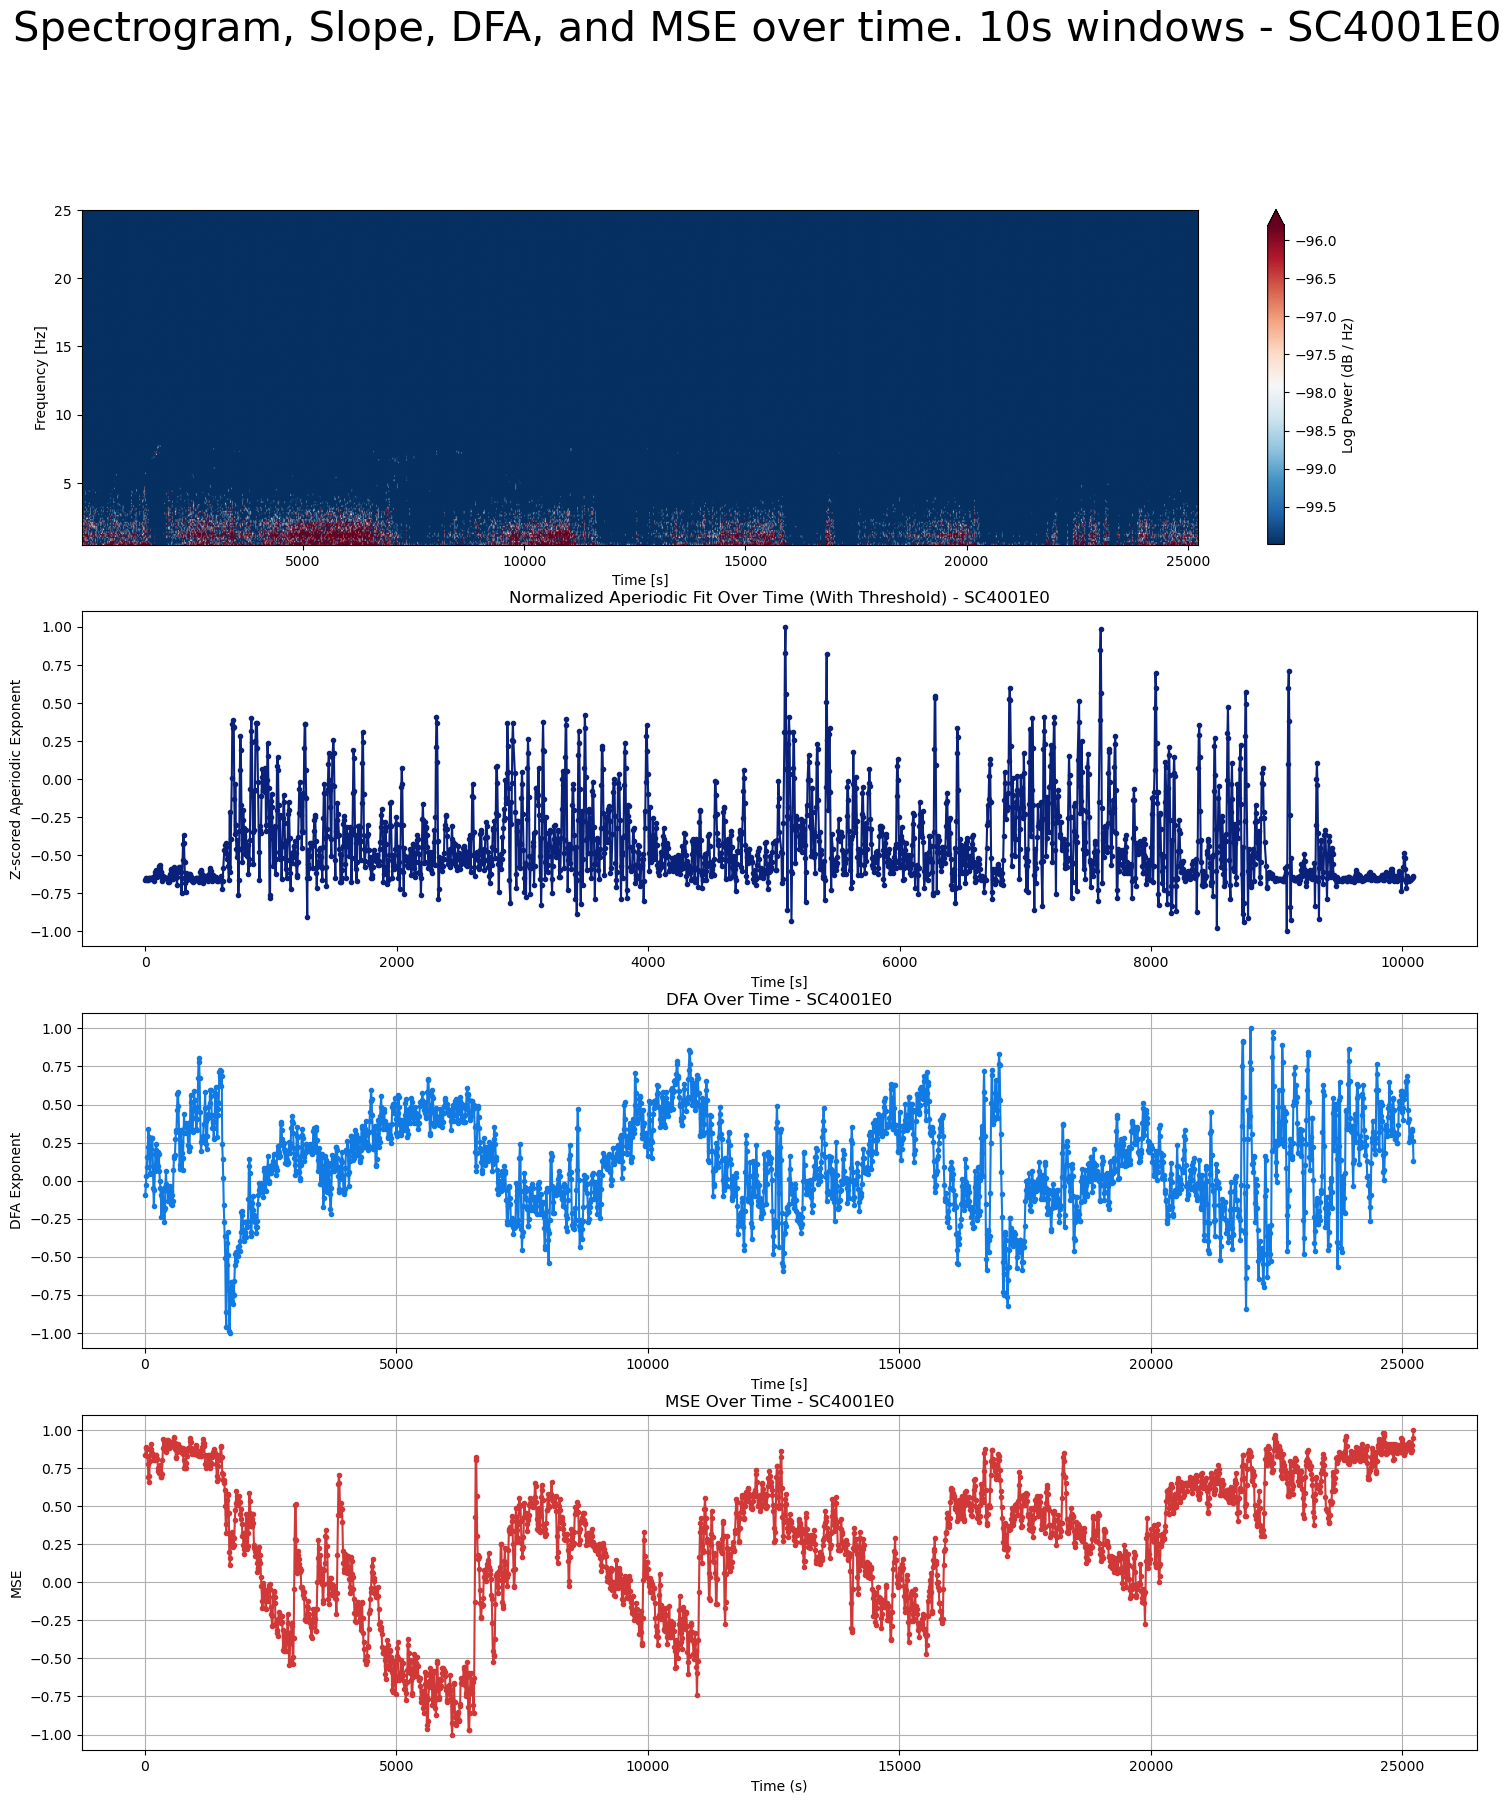

In [115]:
# SPECTROGRAM
nperseg = int(window_size)      # Window Size
fmin, fmax = 0.5, 25

# Create Plot
fig, axs = plt.subplots(4, 1, figsize=(18, 20))
fig.suptitle(f'Spectrogram, Slope, DFA, and MSE over time. {epoch_length}s windows - {subject}', fontsize=30)

Pxx, freqs, bins, im = axs[0].specgram(fpz, NFFT=nperseg, Fs=fs, cmap="RdBu_r", scale="dB")

# Frequency (0.5 Hz ≤ f ≤ 25 Hz)
freq_mask = (freqs >= fmin) & (freqs <= fmax)
freqs = freqs[freq_mask]
Pxx = Pxx[freq_mask, :]

vmin, vmax = np.percentile(10 * np.log10(Pxx + 1e-10), [10, 98])
im.set_clim(vmin, vmax)

axs[0].set_ylabel("Frequency [Hz]")
axs[0].set_xlabel("Time [s]")
cbar = fig.colorbar(im, ax=axs[0], extend='max', label="Log Power (dB / Hz)")
axs[0].set_ylim(fmin, fmax)


# SLOPE
axs[1].plot(filtered_timestamps, normalized_exponents, marker='.', linestyle='-', color=DarkBlue)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Z-scored Aperiodic Exponent')
axs[1].set_title(f'Normalized Aperiodic Fit Over Time (With Threshold) - {subject}')
#axs[1].axhline(0, color='r', linestyle='--', label='Mean')
#axs[1].legend()

# DFA
axs[2].plot(time_stamps, normalized_dfa, marker='.', linestyle='-', color=Blue)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('DFA Exponent')
axs[2].set_title(f'DFA Over Time - {subject}')
axs[2].grid()

axs[3].plot(time_stamps_mse, normalized_mse, marker='.', linestyle='-', color=Red)
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('MSE')
axs[3].set_title(f'MSE Over Time - {subject}')
axs[3].grid()

plt.show()

# 2. Results for Epochs
-Not Suitable.

In [116]:
def find_all_state_epochs(state_array):
    """
    Returns a list of (start_sample_idx, end_sample_idx, state) tuples.
    Assumes each element in state_array represents 1 second of signal.
    """
    epochs = []
    start_idx = 0

    for i in range(1, len(state_array)):
        if state_array[i] != state_array[i - 1]:
            end_idx = i - 1
            state = state_array[start_idx]
            epochs.append((start_idx, end_idx, state))
            start_idx = i

    # Add last epoch
    epochs.append((start_idx, len(state_array) - 1, state_array[start_idx]))
    return epochs

In [117]:
samples_per_state = fs  # If state_array is per second

aperiodic_exponents = []
state_labels = []
epoch_times = []

state_epochs = find_all_state_epochs(states)

for idx, (start_sec, end_sec, state) in enumerate(state_epochs):
    # Convert to sample indices
    start_sample = start_sec * samples_per_state
    end_sample = (end_sec + 1) * samples_per_state  # +1 to include the full last second

    epoch_signal = fpz[start_sample:end_sample]

    # Skip if too short
    if len(epoch_signal) < 2 * fs:
        continue

    # Compute PSD
    freqs, psd = welch(epoch_signal, fs=fs, nperseg=4096)
    freqs, psd = freqs[freqs <= 100], psd[freqs <= 100]

    # Fit aperiodic component
    try:
        fm = SpectralModel(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
        fm.fit(freqs, psd)
        exponent = fm.get_params('aperiodic')[1]
        aperiodic_exponents.append(exponent)
        state_labels.append(state)
        epoch_times.append(idx)
    except Exception as e:
        print(f"Skipping epoch {idx} due to error: {e}")

C:\Users\andri\AppData\Local\Temp\ipykernel_28604\3964025280.py:21: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 3000, using nperseg = 3000
  freqs, psd = welch(epoch_signal, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\3964025280.py:21: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 3000, using nperseg = 3000
  freqs, psd = welch(epoch_signal, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\3964025280.py:21: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 3000, using nperseg = 3000
  freqs, psd = welch(epoch_signal, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\3964025280.py:21: UserWarning: nperseg=4096 is greater than signal length max(len(x), len(y)) = 3000, using nperseg = 3000
  freqs, psd = welch(epoch_signal, fs=fs, nperseg=4096)
C:\Users\andri\AppData\Local\Temp\ipykernel_28604\3964025280.py:21: UserWarning: npe

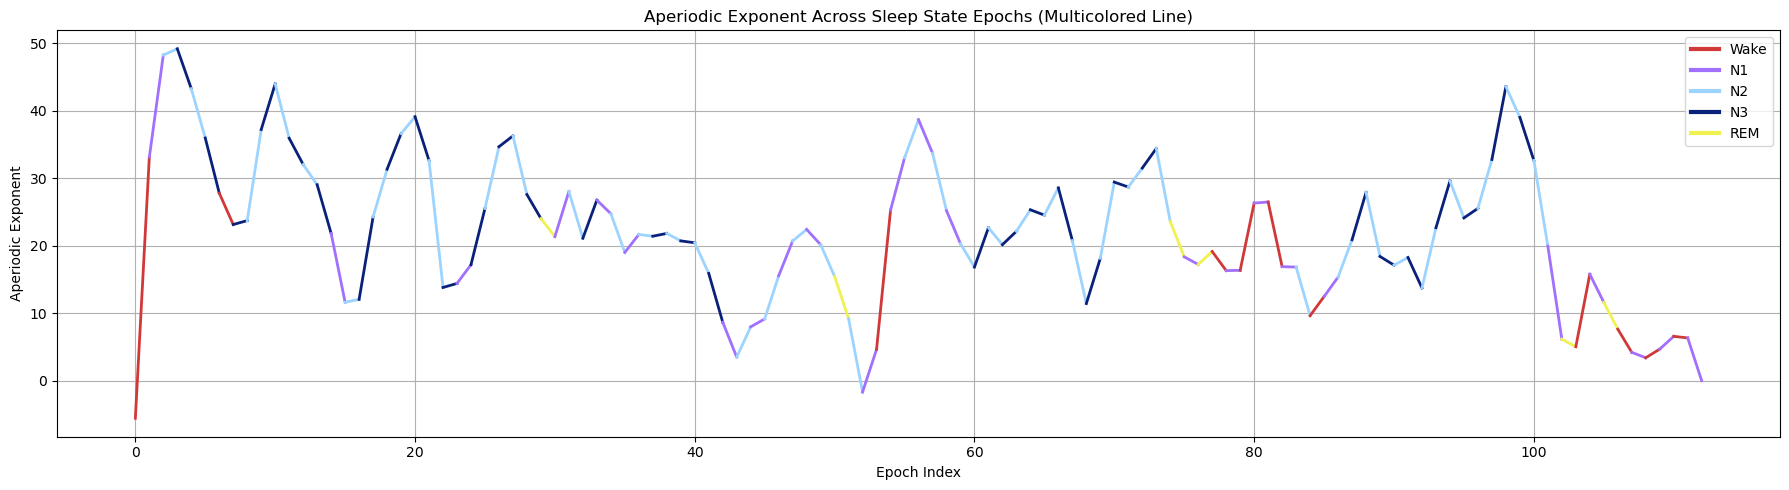

In [118]:
aperiodic_exponents = np.array(aperiodic_exponents)
state_labels = np.array(state_labels)
epoch_times = np.array(epoch_times)

# Remove outliers
threshold_min = np.percentile(aperiodic_exponents, 2)
threshold_max = np.percentile(aperiodic_exponents, 98)
valid = (aperiodic_exponents >= threshold_min) & (aperiodic_exponents <= threshold_max)

#filtered_exponents = aperiodic_exponents[valid]
#filtered_states = state_labels[valid]
#filtered_times = epoch_times[valid]

# Z-score the filtered exponents
#z_exponents = (filtered_exponents - np.mean(filtered_exponents)) / np.std(filtered_exponents)
#filtered_exponents_z = (filtered_exponents - np.mean(filtered_exponents)) / np.std(filtered_exponents)
window_length = 11 if len(aperiodic_exponents) >= 11 else len(aperiodic_exponents) | 1  # ensure it's odd
polyorder = 4

smoothed_exponents = savgol_filter(aperiodic_exponents, window_length=window_length, polyorder=polyorder)

# Color mapping for states
state_map = {0: Red, 1: Purple, 2: LightBlue, 3: DarkBlue, 4: Yellow}
state_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
plt.figure(figsize=(18, 5))


# Plot each line segment with its state color
for i in range(len(epoch_times) - 1):
    x = [epoch_times[i], epoch_times[i + 1]]
    y = [smoothed_exponents[i], smoothed_exponents[i + 1]]
    state = state_labels[i]
    color = state_map.get(state, 'gray')
    plt.plot(x, y, color=color, linewidth=2)

# Mean line
#plt.axhline(0, color='red', linestyle='--', label='Mean')

plt.xlabel('Epoch Index')
plt.ylabel('Aperiodic Exponent')
plt.title('Aperiodic Exponent Across Sleep State Epochs (Multicolored Line)')
plt.grid(True)

# Legend for states
legend_elements = [plt.Line2D([0], [0], color=state_map[s], lw=3, label=state_names[s]) for s in state_map]
#legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='red', label='Mean'))

plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

In [119]:
# First, find the epochs
epochs = find_all_state_epochs(states)  # state_array has 1 sample/sec

dfa_exponents = []
epoch_times = []
epoch_labels = []

for start_sec, end_sec, state in epochs:
    start_sample = start_sec * fs
    end_sample = (end_sec + 1) * fs  # +1 to include the last second

    segment = fpz[start_sample:end_sample]

    #if len(segment) < fs * 2:  # skip very short epochs (e.g. <5 sec)
     #   continue

    try:
        _, _, exp_epoch = compute_fluctuations(segment, fs, n_scales=10,
                                               min_scale=0.05, max_scale=4.0)
        dfa_exponents.append(exp_epoch)
        epoch_times.append((start_sample + end_sample) / 2 / fs)
        epoch_labels.append(state)
    except Exception as e:
        print(f"Skipped epoch due to error: {e}")
        continue

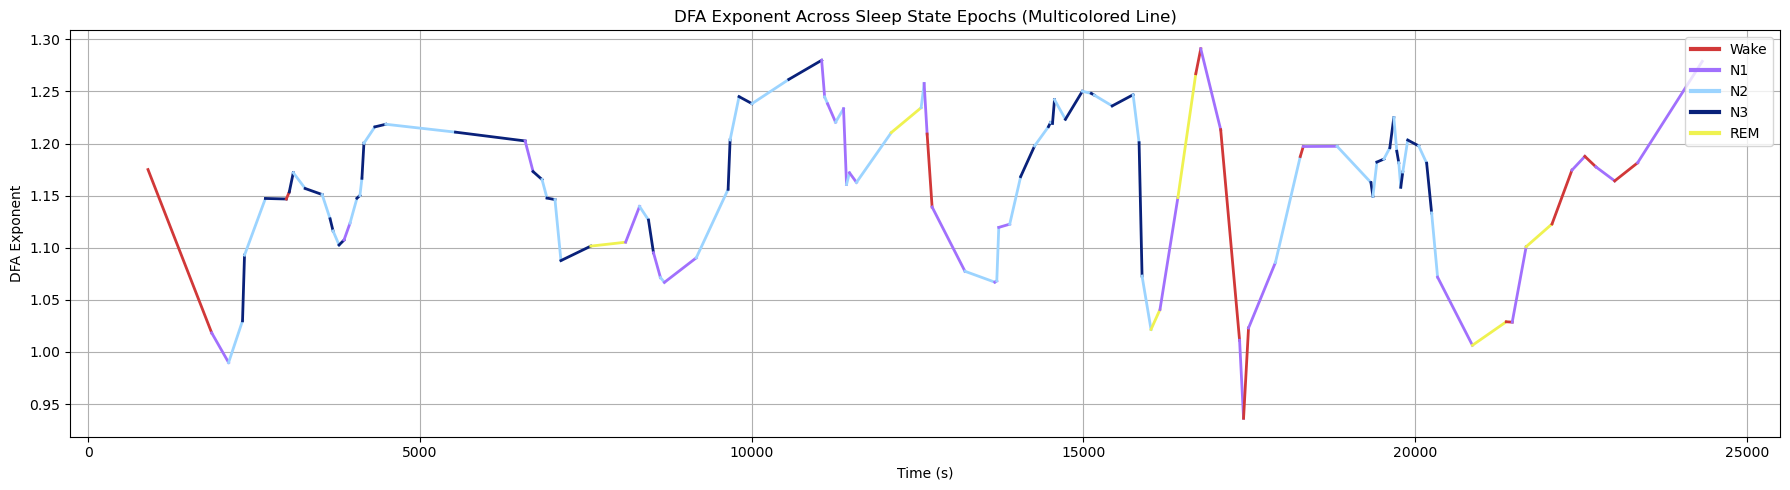

In [120]:
plt.figure(figsize=(18, 5))

window_length = 11 if len(dfa_exponents) >= 11 else len(dfa_exponents) | 1  # ensure it's odd
polyorder = 4

dfa_smoothed_exponents = savgol_filter(dfa_exponents, window_length=window_length, polyorder=polyorder)

# Plot each line segment with its state color
for i in range(len(epoch_times) - 1):
    x = [epoch_times[i], epoch_times[i + 1]]
    y = [dfa_smoothed_exponents[i], dfa_smoothed_exponents[i + 1]]
    state = epoch_labels[i]
    color = state_map.get(state, 'gray')
    plt.plot(x, y, color=color, linewidth=2)


plt.xlabel('Time (s)')
plt.ylabel('DFA Exponent')
plt.title('DFA Exponent Across Sleep State Epochs (Multicolored Line)')
plt.grid(True)

# Legend for states
legend_elements = [plt.Line2D([0], [0], color=state_map[s], lw=3, label=state_names[s]) for s in state_map]

plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

In [121]:
# Create the Multiscale Entropy object
Mobj = EH.MSobject('IncrEn', m=2, R=3, Norm=True)

# Get the sleep stage-defined epochs
epochs = find_all_state_epochs(states)

mse_values_epoch = []
epoch_times_mse = []
epoch_labels_mse = []

for start_sec, end_sec, state in epochs:
    start_sample = start_sec * fs
    end_sample = (end_sec + 1) * fs  # include the end

    segment = fpz[start_sample:end_sample]

    # Skip very short segments (e.g., <2*Scale)
    #if len(segment) < fs * 2:
    #   continue

    try:
        MSx, _ = EH.MSEn(segment, Mobj, Scales=2, Methodx='modified')
        mse_values_epoch.append(np.mean(MSx))
        epoch_times_mse.append((start_sample + end_sample) / 2 / fs)
        epoch_labels_mse.append(state)
    except Exception as e:
        print(f"Skipped epoch due to error: {e}")
        continue

 .

c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: divide by zero encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))
c:\Users\andri\miniconda3\envs\rodent_model\Lib\site-packages\EntropyHub\_IncrEn.py:69: RuntimeWarning: invalid value encountered in divide
  Qk = np.minimum(R, np.floor(abs(Vk)*R/Temp))


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

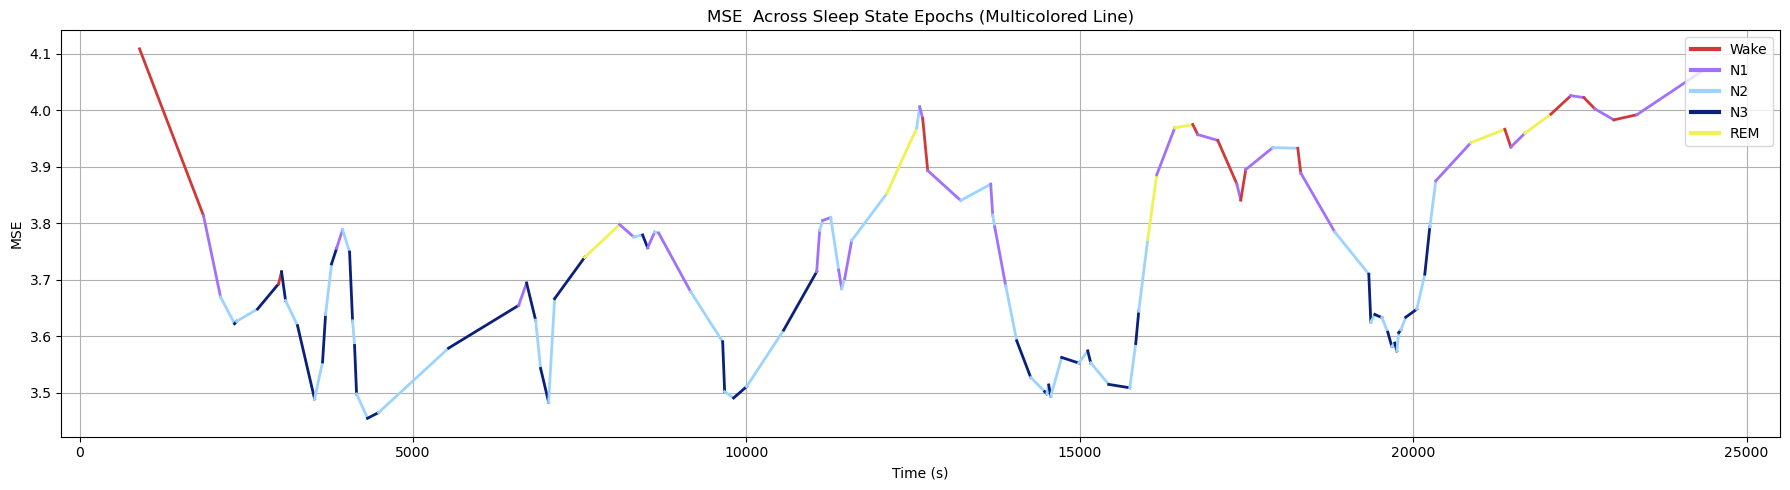

In [122]:
plt.figure(figsize=(18, 5))

window_length = 11 if len(mse_values_epoch) >= 11 else len(mse_values_epoch) | 1  # ensure it's odd
polyorder = 4

mse_smoothed_exponents = savgol_filter(mse_values_epoch, window_length=window_length, polyorder=polyorder)

# Plot each line segment with its state color
for i in range(len(epoch_times_mse) - 1):
    x = [epoch_times_mse[i], epoch_times_mse[i + 1]]
    y = [mse_smoothed_exponents[i], mse_smoothed_exponents[i + 1]]
    state = epoch_labels_mse[i]
    color = state_map.get(state, 'gray')
    plt.plot(x, y, color=color, linewidth=2)


plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.title('MSE  Across Sleep State Epochs (Multicolored Line)')
plt.grid(True)

# Legend for states
legend_elements = [plt.Line2D([0], [0], color=state_map[s], lw=3, label=state_names[s]) for s in state_map]

plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

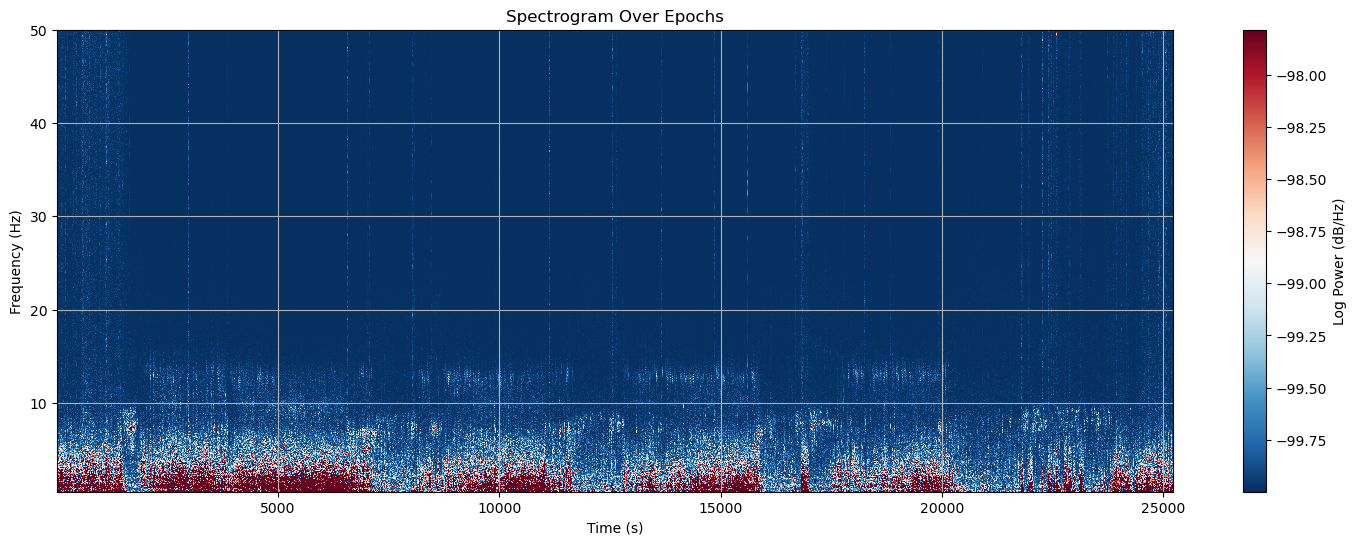

In [123]:
from scipy.signal import spectrogram

fmin, fmax = 0.5, 50
nperseg = int(10 * fs)
noverlap = nperseg // 2

# Get epochs
epochs = find_all_state_epochs(states)

# Init for concatenating results
spec_data = []
spec_times = []
spec_freqs = None
spec_colors = []

time_cursor = 0  # tracks where to place each epoch’s spectrogram

for start_sec, end_sec, state in epochs:
    start_sample = start_sec * fs
    end_sample = (end_sec + 1) * fs
    segment = fpz[start_sample:end_sample]

    # Skip too short segments
    if len(segment) < nperseg:
        continue

    f, t, Sxx = spectrogram(segment, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Filter frequencies
    freq_mask = (f >= fmin) & (f <= fmax)
    Sxx = Sxx[freq_mask, :]
    f = f[freq_mask]

    if spec_freqs is None:
        spec_freqs = f

    # Time correction to place each epoch properly on x-axis
    corrected_t = t + time_cursor
    spec_times.append(corrected_t)
    spec_data.append(Sxx)
    spec_colors.append(state)

    time_cursor += (len(segment) / fs)

# Concatenate
spec_data = np.concatenate(spec_data, axis=1)
spec_times = np.concatenate(spec_times)

# Convert to dB scale
Sxx_dB = 10 * np.log10(spec_data + 1e-10)

# Plot
plt.figure(figsize=(18, 6))
im = plt.pcolormesh(spec_times, spec_freqs, Sxx_dB, shading='auto', cmap='RdBu_r')
vmin, vmax = np.percentile(Sxx_dB, [10, 98])
im.set_clim(vmin, vmax)
plt.colorbar(label='Log Power (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(fmin, fmax)
plt.title('Spectrogram Over Epochs')
plt.grid()
plt.show()

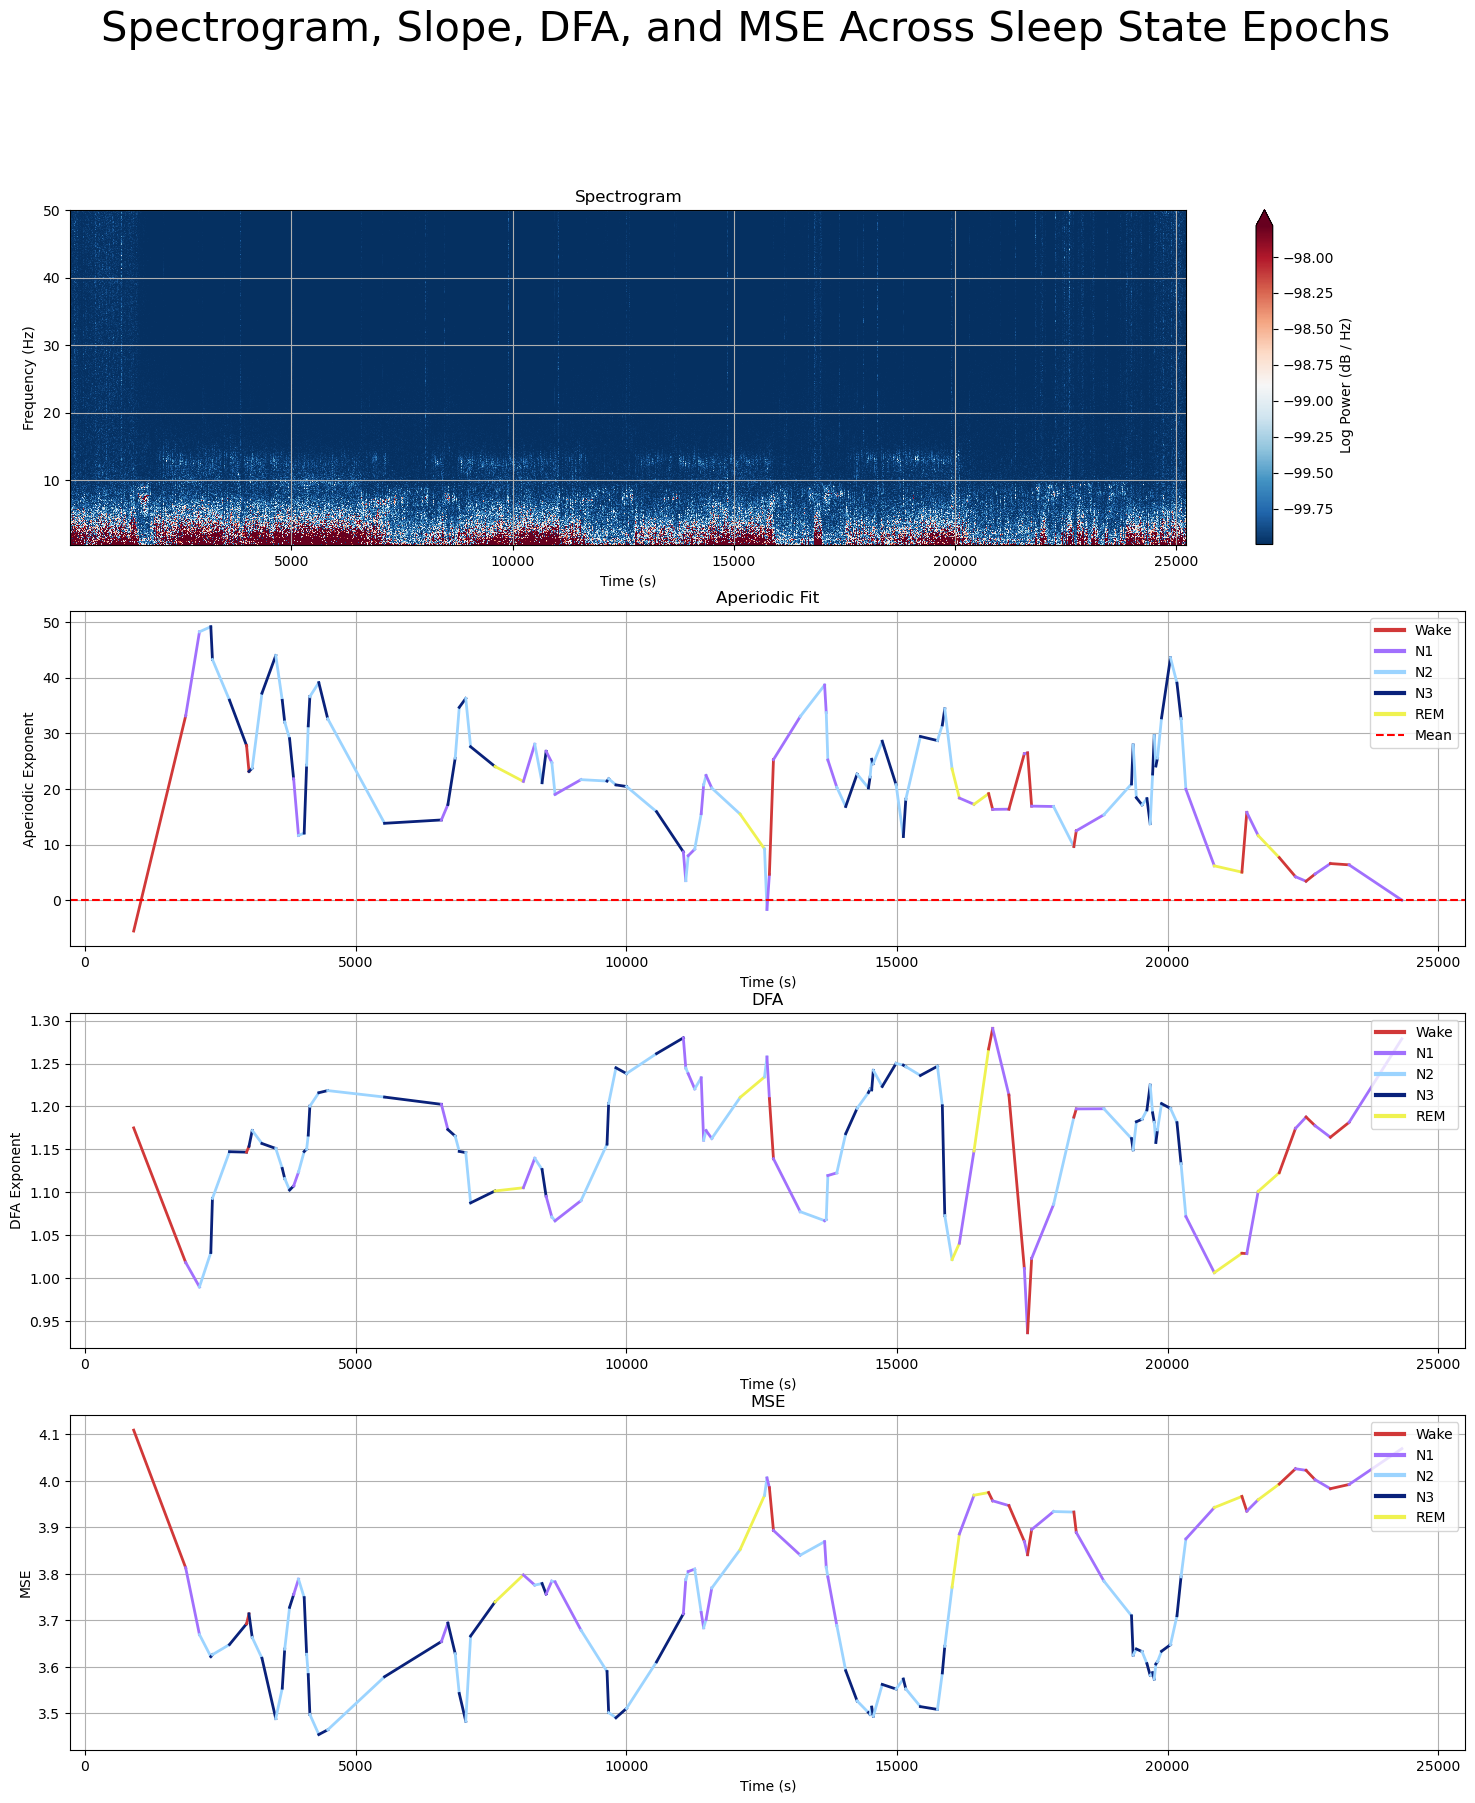

In [124]:
fig, axs = plt.subplots(4, 1, figsize=(18, 20))
fig.suptitle('Spectrogram, Slope, DFA, and MSE Across Sleep State Epochs', fontsize=30)

#SPECTROGRAM
im = axs[0].pcolormesh(spec_times, spec_freqs, Sxx_dB, shading='auto', cmap='RdBu_r')
vmin, vmax = np.percentile(Sxx_dB, [10, 98])
im.set_clim(vmin, vmax)
cbar = fig.colorbar(im, ax=axs[0], extend='max', label="Log Power (dB / Hz)")
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('Spectrogram')
axs[0].grid()

# SLOPE
for i in range(len(epoch_times) - 1):
    x = [epoch_times[i], epoch_times[i + 1]]
    y = [smoothed_exponents[i], smoothed_exponents[i + 1]]
    state = state_labels[i]
    color = state_map.get(state, 'gray')
    axs[1].plot(x, y, color=color, linewidth=2)

axs[1].axhline(0, color='red', linestyle='--', label='Mean')

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Aperiodic Exponent')
axs[1].set_title('Aperiodic Fit')
axs[1].grid(True)

legend_elements = [plt.Line2D([0], [0], color=state_map[s], lw=3, label=state_names[s]) for s in state_map]
legend_elements.append(plt.Line2D([0], [0],  linestyle='--', color='red', label='Mean'))

axs[1].legend(handles=legend_elements, loc='upper right')

# DFA
for i in range(len(epoch_times) - 1):
    x = [epoch_times[i], epoch_times[i + 1]]
    y = [dfa_smoothed_exponents[i], dfa_smoothed_exponents[i + 1]]
    state = epoch_labels[i]
    color = state_map.get(state, 'gray')
    axs[2].plot(x, y, color=color, linewidth=2)

axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('DFA Exponent')
axs[2].set_title('DFA')
axs[2].grid(True)

legend_elements = [plt.Line2D([0], [0], color=state_map[s], lw=3, label=state_names[s]) for s in state_map]

axs[2].legend(handles=legend_elements, loc='upper right')

#MSE
for i in range(len(epoch_times_mse) - 1):
    x = [epoch_times_mse[i], epoch_times_mse[i + 1]]
    y = [mse_smoothed_exponents[i], mse_smoothed_exponents[i + 1]]
    state = epoch_labels_mse[i]
    color = state_map.get(state, 'gray')
    axs[3].plot(x, y, color=color, linewidth=2)


axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('MSE')
axs[3].set_title('MSE')
axs[3].grid(True)

# Legend for states
legend_elements = [plt.Line2D([0], [0], color=state_map[s], lw=3, label=state_names[s]) for s in state_map]

axs[3].legend(handles=legend_elements, loc='upper right')

plt.show()